# Landau Damping

Text adapted from [1]: *While fast sheets are able to excite an electrostatic wake in their rear, the resulting electrostatic wake can also accelerate sheets moving slightly slower than its phase velocity* [2, 3]*.
Electrostatic modes are therefore self-consistently generated by particles moving close to its phase velocity, while being damped by particles moving slightly slower. However, since a plasma in thermal equilibrium follows a Maxwellian distribution in velocity space, there exist on average more particles moving faster than the wave, than those moving slower. Therefore, on average, the modes will be damped. This mechanism is known as Landau damping* [3] *and is an inherently collisionless kinetic process that the sheet model has been shown to recover* [2]. <br>
    *For a given mode $m$, with a wavelength $\lambda_m = 2L/m$ and wave vector $k_m = 2\pi/\lambda_m$, we can compute its wave frequency and damping time by finding numerically the roots of the dispersion relation for $k=k_m$* [2]:

\begin{equation}
    1 = \frac{\omega_p^2}{k^2} \int^\infty_{-\infty} \frac{\partial \hat{f}_0/\partial v}{v - (\omega/k)} dv
\end{equation}

*where $\hat{f}_0$ corresponds to the distribution function in velocity space. The solution will have both a real and imaginary part. The real part corresponds to the wave angular frequency, while the imaginary part corresponds to the inverse of the damping time.*

In this notebook we will quickly show how to numericall resolve this dispersion relation, and demonstrate that modes are indeed self-consistently generated and damped in accordance with the predicted decay time when doing simulations with the GNS. For a more in-depth analysis of the damping rates check [Landau_Damping_Extended.ipynb](Landau_Damping_Extended.ipynb).

#### References
[1] D. Carvalho et al., arXiv:2310.17646 (2023) - See Sections 6.4 and 6.6 <br>
[2] J. Dawson, Phys. Fluids 5.4 (1962) - See pp. 450 <br>
[3] F. Chen, Introduction to Plasma Physics and Controlled Fusion Vol. 1 (1984) - See Chapter 7 <br>
[4] J. Jackson, Journal of Nuclear Energy. Part C, Plasma Physics, Accelerators, Thermonuclear
Research 1 171 (1960)

In [1]:
import os
import jax
import sys
import pickle
import numpy as np

from pathlib import Path
from tqdm.auto import tqdm

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

sys.path.append('../..')
from gns.simulator import SMGNS
from sheet_model.utils import get_x_eq, get_dx_eq, get_mode_info, get_mode_evolution, \
                              get_relaxation_time

## dont let JAX preallocate all GPU memory + free unused arrays 
## https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
## makes code slower
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

## Solving the dispersion relation

Below, we are reproducing an image from [4], where we compare the numerical solution of the dispersion relation and an approximation that is commonly used:
$$
Re(\omega) \simeq \sqrt{\omega_p^2 + kv_{th}^2} \\
$$
$$
Im(\omega) \simeq -\sqrt{\frac{\pi}{8}}\omega_p\left(\frac{\omega_p}{kv_{th}}\right)^3 \exp\left(-\frac{\omega_p^2}{2k^2v_{th}^2} + \frac{3}{2}\right)
$$

which is similar to what Dawson used in his original work [2] and is our initial guess for the numerical solver (solver does not converge for larger $k$).

Since we will be tracking modes in the region $k\lambda_D \in [0.4;0.5]$, there is a significant difference between using the numerical damping rate, and the approximation (they are only equal around $k\lambda_D=0.5$ which is the mode that Dawson selected in [2]).

  0%|          | 0/200 [00:00<?, ?it/s]

/home/dcarvalho/dawgnnson-sheet-model/notebooks/examples/../../sheet_model/utils.py:99: RuntimeWarning: invalid value encountered in scalar multiply
  z = 1j*np.sqrt(np.pi)*wofz(xc)


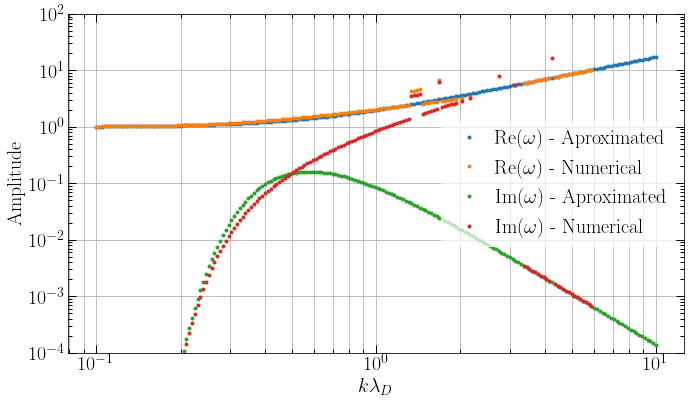

In [2]:
from sheet_model.utils import get_roots_dispersion_relation

wnr = []
wni = []
war = []
wai = []


K = np.logspace(-1,1,200)

for k in tqdm(K):
    w_num, w_approx = get_roots_dispersion_relation(k)
    if w_num is None:
        wnr.append(0)
        wni.append(0)
    else:
        wnr.append(np.real(w_num))
        wni.append(np.imag(-w_num))
    war.append(np.real(w_approx))
    wai.append(np.imag(-w_approx))
    
plt.figure(figsize=(10,6))
plt.plot(K, war, '.', label='Re($\omega$) - Aproximated')
plt.plot(K, wnr, '.', label='Re($\omega$) - Numerical')
plt.plot(K, wai, '.', label='Im($\omega$) - Aproximated')
plt.plot(K, wni, '.', label='Im($\omega$) - Numerical')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k\lambda_D$')
plt.ylabel('Amplitude')
plt.grid(True, which="both", axis="x")
plt.grid(True, axis="y")
plt.ylim(1e-4,1e2)
plt.tight_layout()
plt.show()

## Tracking Electrostatic Modes Evolution

In [3]:
# system properties
n_sheets = 1000
t_max = 500
boundary = 'reflecting' 

dx_eq = get_dx_eq(n_sheets) 
x_eq = get_x_eq(n_sheets)

v_th = 5 # [dx_eq w_p]
v_std_0 = 5.2 # slightly higher value to initialize sheet velocities

t_relax = get_relaxation_time(v_std_0)


# GNS
model_folder = Path(f'../../models/final/dt1e-1/4/')
gns = SMGNS(model_folder, boundary, verbose=False)

In [4]:
# modes that will be followed
# if v_ph > 3 v_th, almost no particles will exist to resonate with the wave
# if v_ph ~ 2 v_th, one is too close to plasma bulk (and mode decays very fast)
MODES = [24, 26, 28, 30, 32]
for mode in MODES:
    mode_info = get_mode_info(mode, n_sheets=n_sheets, v_th=v_th, num=True)
    print(f'Mode: {mode}')
    print(f'lambda: {mode_info["lambda"]:0.1f} [dx_eq]')
    print(f'v_ph/v_th: {mode_info["v_ph"]/v_th:0.1f}')
    print(f'w/w_p: {mode_info["w"]:0.2f}')
    print(f'1/gamma', 1/mode_info["gamma"], '[w_p^-1]')
    print(f'k*lambda_D: {mode_info["k"]*v_th:.2f}')
    print()

Mode: 24
lambda: 83.3 [dx_eq]
v_ph/v_th: 3.3
w/w_p: 1.26
1/gamma -19.860878282131434 [w_p^-1]
k*lambda_D: 0.38

Mode: 26
lambda: 76.9 [dx_eq]
v_ph/v_th: 3.2
w/w_p: 1.30
1/gamma -13.823395044401213 [w_p^-1]
k*lambda_D: 0.41

Mode: 28
lambda: 71.4 [dx_eq]
v_ph/v_th: 3.0
w/w_p: 1.34
1/gamma -10.254840090868932 [w_p^-1]
k*lambda_D: 0.44

Mode: 30
lambda: 66.7 [dx_eq]
v_ph/v_th: 2.9
w/w_p: 1.38
1/gamma -7.967400242762393 [w_p^-1]
k*lambda_D: 0.47

Mode: 32
lambda: 62.5 [dx_eq]
v_ph/v_th: 2.8
w/w_p: 1.42
1/gamma -6.409046841688435 [w_p^-1]
k*lambda_D: 0.50



In [5]:
# perform several simulations (takes some time)
N_SIM = 50
np.random.seed(42)

M_N_Am = {m:[] for m in MODES} # stores amplitudes (mode, #simulations, #timesteps)
M_N_dAm = {m:[] for m in MODES} # stores amplitude rate of change (mode, #simulations, #timesteps)

for n in tqdm(range(N_SIM)):
    
    x0 = x_eq
    v0 = np.random.normal(0, v_std_0, n_sheets) * dx_eq

    X, V, X_eq, E = gns.pred_rollout(x0, 
                                  v0,
                                  x_eq,
                                  dt=gns.dt_train,
                                  t_max=t_max,
                                  n_guards=5,
                                  verbose=False,
                                  track_sheets=False,
                                  np_=np)

    if boundary == 'periodic':
        # for periodic boundary have to force 
        # equilibrium positions to be inside the box
        # and sort sheets accordingly for correct mode amplitude calculation
        aux = X_eq // 1
        X -= aux
        X_eq -= aux
        i_sort = np.argsort(X_eq, axis=-1)
        X = np.take_along_axis(X, i_sort, -1)
    
    if n == 0:
        # just to check if simulator is behaving well
        print(f'dE/E0: {np.mean(E[-int(2*np.pi/gns.dt_train):]-E[0])/E[0]}')
    
    for m in MODES:
        Am, dAm = get_mode_evolution(m, X, x_eq, gns.dt_train)
        M_N_Am[m].append(Am)
        M_N_dAm[m].append(dAm)

for m in MODES:
    M_N_Am[m] = np.array(M_N_Am[m])
    M_N_dAm[m] = np.array(M_N_dAm[m])

  0%|          | 0/50 [00:00<?, ?it/s]

dE/E0: 0.004966051317751408


In [6]:
## save results 
## useful to store since simulation take a long time to run
with open('ld_Am.pkl', 'wb') as f:
    pickle.dump(M_N_Am, f)

with open('ld_dAm.pkl', 'wb') as f:
    pickle.dump(M_N_dAm, f)

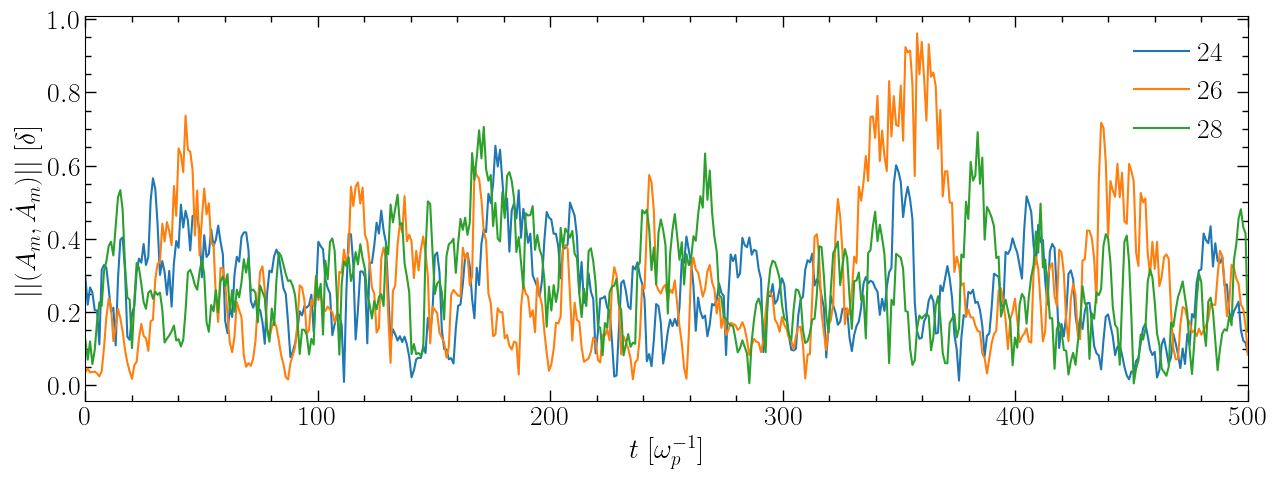

In [7]:
# examples of mode evolution
m = MODES[0]
plt.figure(figsize=(15,5))
for m in MODES[:3]:
    plt.plot(np.linspace(0, t_max, len(Am)//10),
             np.sqrt(M_N_Am[m][0,::10].T**2 + M_N_dAm[m][0,::10].T**2) / dx_eq, 
             label=m)

plt.legend()
plt.ylabel('$||(A_m, \dot{A}_m)||$ [$\delta$]')
plt.xlabel('$t [\omega_p^{-1}]$')
plt.xlim(0, t_max)
plt.show()

In [8]:
def get_i_track(A, dA, r, dr, di, n_skip=0):
    """
    Return list of array indices (time) where to start tracking mode trajectory since its 
    amplitude became close to the defined threshold value.
    
    Args:
        A - mode amplitude (#timesteps)
        dAm - mode amplitude rate of change (#timesteps)
        r - threshold value
        dr - allowed range around threshold (abs(sqrt(A**2 + dAm**2)) - r) < dr)
        di - desired length of trajectory (avoid duplicate trajectories)
        n_skip - number of indices to skip (initialization of fields is not "clean")
        
    Returns:
        i_start
    """
    
    i_start = np.squeeze(np.argwhere(np.abs(np.sqrt(A**2 + dA**2) - r) < dr))
    # remove indices that do not provide full trajectory
    i_start = i_start[i_start + di < len(A)]
    # remove indices below n_skip
    i_start = i_start[i_start > n_skip]
    
    if i_start.size != 0:
        i_no_duplicates = [i_start[0]]
        for i in i_start:
            # only add if beginning of new trajectory is not included
            # in previous interval
            if i - i_no_duplicates[-1] > di:
                i_no_duplicates.append(i)
        

        i_start = np.array(i_no_duplicates, dtype=np.int64)

    return i_start

Mode: 24
lambda: 83.3 [dx_eq]
v_ph/v_th: 3.3
v_ph/v_th: 3.2
w/w_p: 1.26
1/gamma: -19.86 [w_p^-1]
k*lambda_D: 0.38

41.77713791051667
#tracks 349


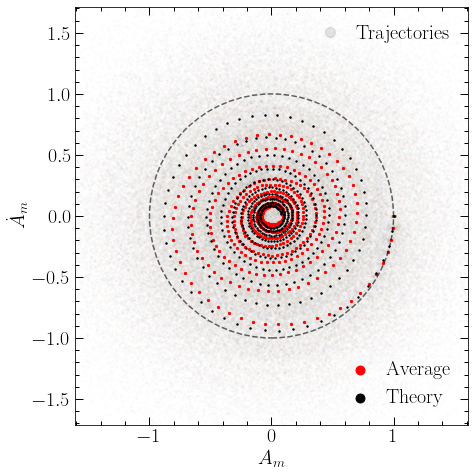

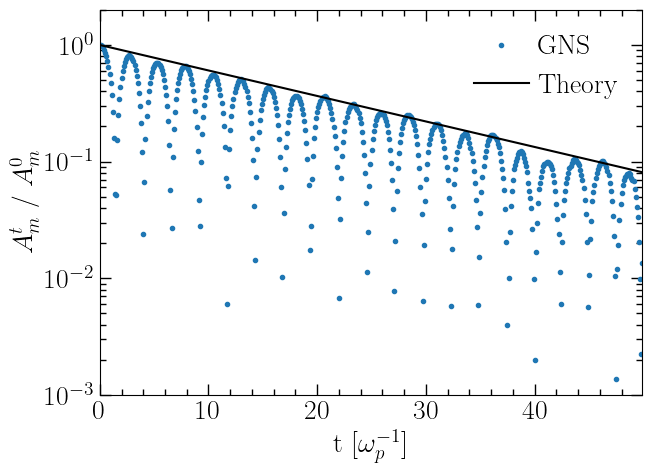

Mode: 26
lambda: 76.9 [dx_eq]
v_ph/v_th: 3.2
v_ph/v_th: 3.0
w/w_p: 1.30
1/gamma: -13.82 [w_p^-1]
k*lambda_D: 0.41

40.1381757892293
#tracks 361


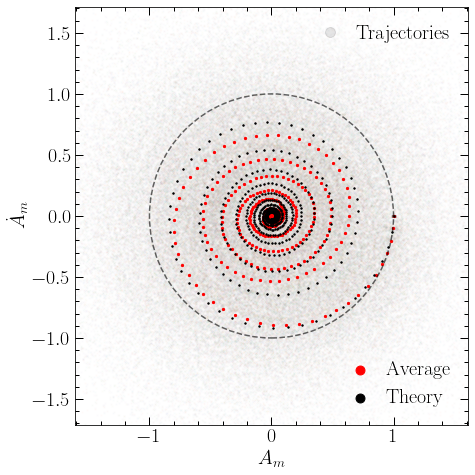

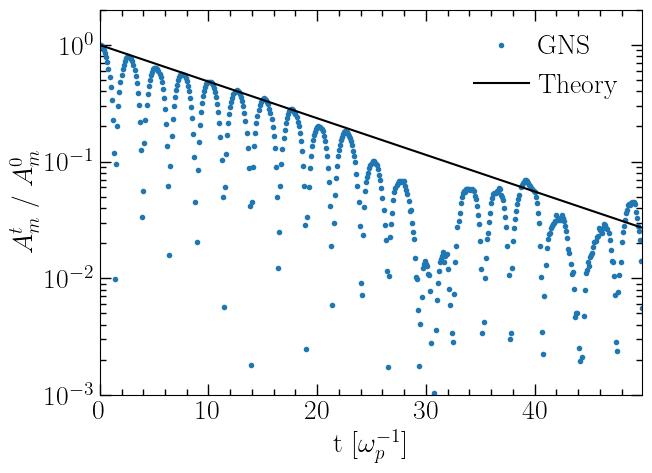

Mode: 28
lambda: 71.4 [dx_eq]
v_ph/v_th: 3.0
v_ph/v_th: 2.9
w/w_p: 1.34
1/gamma: -10.25 [w_p^-1]
k*lambda_D: 0.44

38.678113988526185
#tracks 360


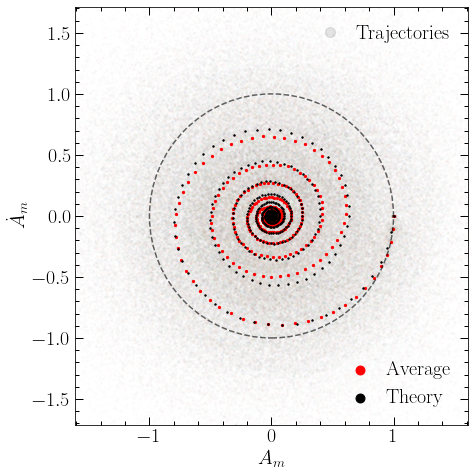

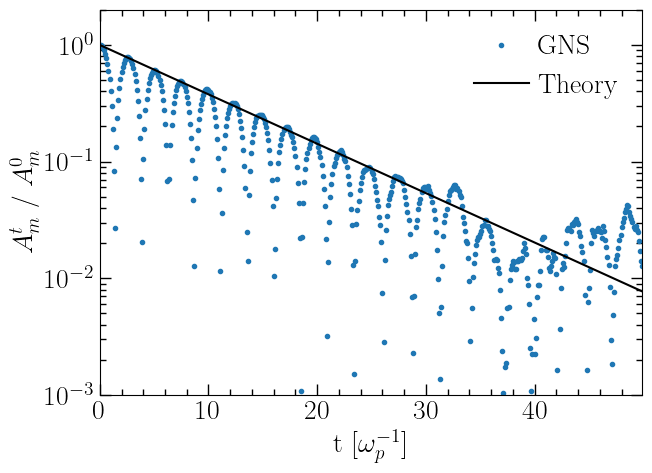

Mode: 30
lambda: 66.7 [dx_eq]
v_ph/v_th: 2.9
v_ph/v_th: 2.7
w/w_p: 1.38
1/gamma: -7.97 [w_p^-1]
k*lambda_D: 0.47

37.36660810931953
#tracks 362


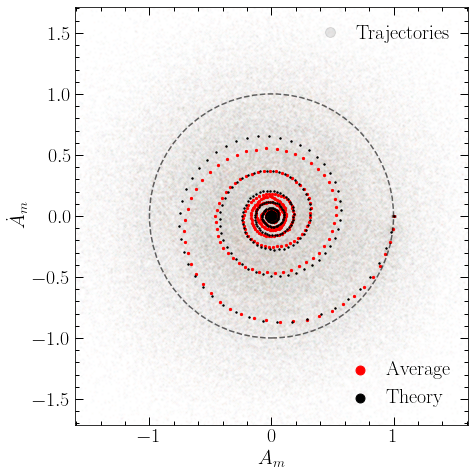

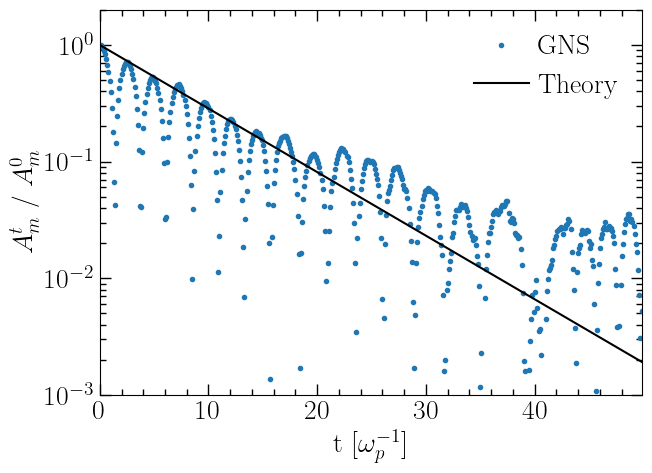

Mode: 32
lambda: 62.5 [dx_eq]
v_ph/v_th: 2.8
v_ph/v_th: 2.6
w/w_p: 1.42
1/gamma: -6.41 [w_p^-1]
k*lambda_D: 0.50

36.18006272791338
#tracks 365


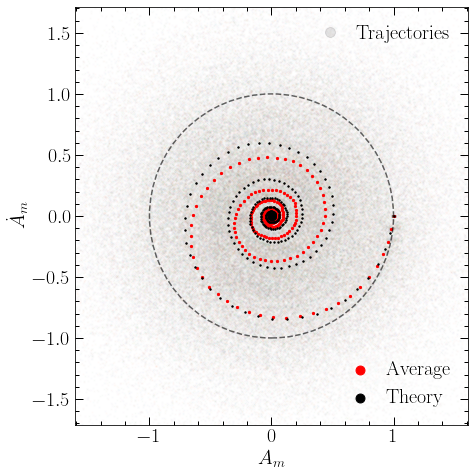

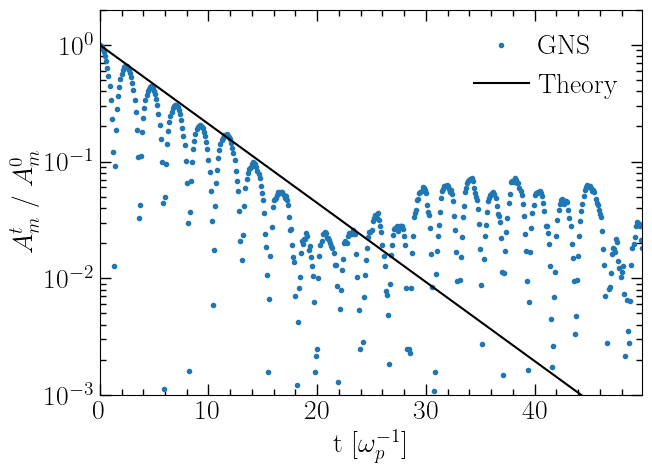

In [13]:
for mode in MODES:
    
    N_Am = M_N_Am[mode]
    N_dAm = M_N_dAm[mode]
    
    mode_info = get_mode_info(mode, n_sheets=n_sheets, v_th=v_th, num=True)
    print(f'Mode: {mode}')
    print(f'lambda: {mode_info["lambda"]:0.1f} [dx_eq]')
    print(f'v_ph/v_th: {mode_info["v_ph"]/v_th:0.1f}')
    print(f'v_ph/v_th: {mode_info["v_ph_approx"]/v_th:0.1f}')
    print(f'w/w_p: {mode_info["w"]:0.2f}')
    print(f'1/gamma: {1/mode_info["gamma"]:.2f} [w_p^-1]')
    print(f'k*lambda_D: {mode_info["k"]*v_th:.2f}')
    print()
    
    R = 0.3 * dx_eq
    dR = R * 0.01
    di = int(50/gns.dt_train)
    t = np.arange(di) * gns.dt_train
    
    # estimate of bounce-time (i.e. when we should stop having linear damping)
    print(2*np.pi/np.sqrt(R/dx_eq*mode_info['k']))

    n_tracks = 0

    rotated = []

    plt.figure(figsize=(7,7))

    for Am, dAm in zip(N_Am, N_dAm):

        i_track = get_i_track(Am, dAm, R, dR, di, n_skip=14/gns.dt_train)
        n_tracks += len(i_track)

        if i_track.size != 0:

            for i in i_track:
                # angle in phasespace where trajectory started
                theta = -np.arctan(dAm[i]/Am[i])
                if Am[i] < 0:
                    theta += np.pi

                # create the 2x2 rotation matrix
                rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                            [np.sin(theta), np.cos(theta)]])

                # apply the rotation matrix so trajectory starts at theta = 0
                rotated_vector = np.dot(rotation_matrix, np.vstack([Am[i:i+di], dAm[i:i+di]]))

                rotated.append(rotated_vector)
                plt.scatter(*rotated_vector/R, s=2, alpha=0.01, rasterized=True)


    print('#tracks', n_tracks)

    if n_tracks != 0:
        rotated = np.array(rotated)
        avg = plt.scatter(*np.mean(np.array(rotated), axis=0)/R, color='r', s=5, label='Average')

        aux = np.exp(mode_info['gamma']*t)
        theory = plt.scatter(aux*np.cos(t*mode_info['w']),
                            -aux*np.sin(t*mode_info['w'])), 
                            color='black', s=2, label='Theory')


        ax = plt.gca()
        circle = plt.Circle((0, 0), 1, linestyle='--', color='k', fill=False, alpha=0.6, linewidth=1.5)
        ax.add_patch(circle)
        
        trajectory = mlines.Line2D([], [], color='k', marker='o', linestyle='None',
                                      markersize=10, label='Trajectories', alpha=0.1)
        legend2 = plt.legend(handles=[trajectory], loc='upper right', framealpha=0.2)
        legend = plt.legend(handles=[avg, theory], loc='lower right', framealpha=0.2)
        for l in legend.legendHandles:
            l._sizes = [80]
        ax.add_artist(legend2)
        ax.axis('equal')
        ax.set_xlim(-1.6, 1.6)
        ax.set_ylim(-1.6, 1.6)
        ax.set_xlabel('$A_m$')
        ax.set_ylabel('$\dot{A}_m$')
        plt.tight_layout()
        plt.savefig(f'../img/ld_m{mode}.pdf')
        plt.show()

        plt.plot(t, np.abs(np.mean(np.array(rotated), axis=0))[0]/R, '.', label='GNS')
        plt.plot(t, np.exp(mode_info['gamma']*t), c='k', label='Theory')
        #plt.plot(t, np.exp(mode_info['gamma_approx']*t), c='r', label='Theory Approx')
        plt.xlabel('t [$\omega_p^{-1}$]')
        plt.ylabel('$A_m^t$ / $A_m^0$')
        plt.yscale('log')
        plt.xlim(0,t[-1])
        plt.ylim(1e-3, 2e0)
        plt.legend()
        plt.show()


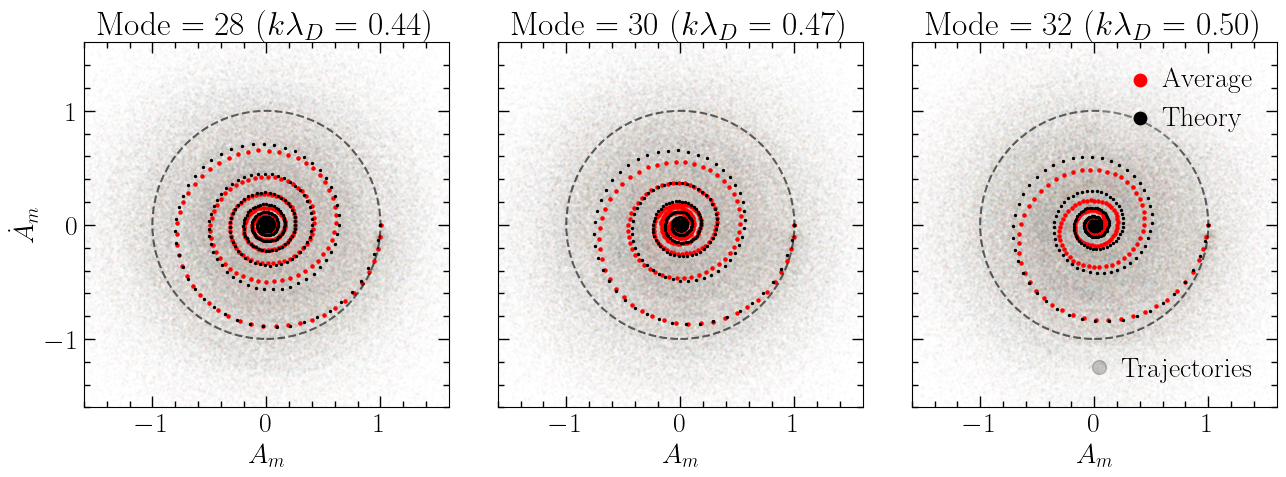

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(13, 5), 
                       gridspec_kw={'wspace':0.05, 'left':0.05, 'right':0.99, 'bottom':0.15}, 
                       sharey=True, sharex=True)



for im, mode in enumerate([28, 30, 32]):
    
    N_Am = M_N_Am[mode]
    N_dAm = M_N_dAm[mode]
    
    R = 0.3 * dx_eq
    dR = R * 0.01
    di = int(50/gns.dt_train)
    t = np.arange(di) * gns.dt_train

    rotated = []
    mode_info = get_mode_info(mode, n_sheets=n_sheets, v_th=v_th, num=True)

    for Am, dAm in zip(N_Am, N_dAm):

        i_track = get_i_track(Am, dAm, R, dR, di, n_skip=14/gns.dt_train)
        
        if i_track.size != 0:

            for i in i_track:

                theta = -np.arctan(dAm[i]/Am[i])
                if Am[i] < 0:
                    theta += np.pi

                # Create the 2x2 rotation matrix
                rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                            [np.sin(theta), np.cos(theta)]])

                # Apply the rotation matrix to the vector
                rotated_vector = np.dot(rotation_matrix, np.vstack([Am[i:i+di], dAm[i:i+di]]))

                rotated.append(rotated_vector)
                ax[im].scatter(*rotated_vector/R, s=2, alpha=0.01, rasterized=True)

    if n_tracks != 0:
        rotated = np.array(rotated)
        avg = ax[im].scatter(*np.mean(np.array(rotated), axis=0)/R, 
                             color='r', s=5, label='Average')

        aux = np.exp(mode_info['gamma']*t)
        theory = ax[im].scatter(aux*np.cos(t*2*np.pi/(mode_info['lambda']/mode_info['v_ph'])),
                                -aux*np.sin(t*2*np.pi/(mode_info['lambda']/mode_info['v_ph'])), 
                                color='black', s=2, label='Theory')


        circle = plt.Circle((0, 0), 1, linestyle='--', color='k', fill=False, alpha=0.6, linewidth=1.5)
        ax[im].add_patch(circle)
        ax[im].set_title(f'Mode = {mode} ($k\lambda_D$ = {mode_info["k"]*v_th:.2f})')

        
plt.setp(ax[0], ylabel='$\dot{A}_m$')
plt.setp(ax, xlabel='$A_m$')
plt.setp(ax, xlim=[-1.6,1.6])
plt.setp(ax, ylim=[-1.6,1.6])
plt.setp(ax, aspect='equal')

trajectory = mlines.Line2D([], [], color='k', marker='o', linestyle='None',
                              markersize=10, label='Trajectories', alpha=0.2)
legend2 = plt.legend(handles=[trajectory], loc='lower right', framealpha=0.2, handletextpad=-0.2)
legend = plt.legend(handles=[avg, theory], loc='upper right', framealpha=0.2, handletextpad=-0.2)

for l in legend.legendHandles:
    l._sizes = [80]

ax[-1].add_artist(legend2)

plt.savefig(f'../img/ld_multiple.pdf')
plt.show()